# Flood inundation mapping and monitoring using SAR data and deep learning
> * 🔬 Data Science
> * 🥠 Deep Learning and pixel classification

## Table of Contents

* [Introduction](#1)
* [Necessary imports](#2)
* [Connect to your GIS](#3)
* [Export training data](#4)
* [Model training](#5)
  * [Get training data](#6)
  * [Prepare data](#7)
  * [Visualize training data](#8)
  * [Load model architecture](#9)
  * [Train the model](#10)
  * [Visualize results in validation set](#11)
  * [Evaluate model performance](#12)
  * [Save the model](#13)
* [Model inferencing](#14)
* [Results visualization](#15)
  * [Flood inundation mapping](#16)
  * [Estimation of flood inundated area](#17)
  * [Infrastructural inundation assessment](#18)
* [Conclusion](#19)

## Introduction<a class="anchor" id="1"></a>

Flooding is one of the most frequent and costly forms of natural disasters. They often strike without warning and can occur when large volumes of water fall in a short time, causing flash floods. Flood mapping is typically performed using the following methods:

- Aerial observations
- Ground surveys

However, when flooding is widespread, these methods become prohibitively expensive and time consuming. Furthermore, aerial observation and optical imagery can often prove difficult, if not impossible, due to obstructive weather conditions. During flooding conditions, clouds can prevent the use of optical satellite imagery for visualization and analysis. In these instances, synthetic-aperture radar (SAR) allows us to penetrate through clouds and hazy atmospheric conditions to continuously observe and map flooding.

In 2019, severe flooding occurred in the Midwest of the United States. Also known as the Great Flood of 2019, 14 million people were affected across multiple states. In this analysis, we will perform flood mapping and infrastructural inundation mapping of the St. Peters region of Missouri, which was one of the affected areas during the flood.

## Necessary imports<a class="anchor" id="2"></a>

In [1]:
import os
from datetime import datetime
from pathlib import Path

from arcgis.gis import GIS
from arcgis.learn import prepare_data, UnetClassifier
from arcgis.raster import Raster, convert_raster_to_feature
from arcgis.features.manage_data import overlay_layers
from arcgis.features.analysis import dissolve_boundaries

## Connect to your GIS<a class="anchor" id="3"></a>

In [1]:
from arcgis import GIS
gis = GIS('home')
gis_ent = GIS('https://pythonapi.playground.esri.com/portal')

## Export training data<a class="anchor" id="4"></a>

Here, we convert the Sentinel-1 GRD VH polarization band to a 3 band raster using [Export Raster](https://pro.arcgis.com/en/pro-app/2.8/help/data/imagery/export-or-convert-raster-datasets.htm). Under the `Render Settings` section, once `Use Renderer` is checked, `Force RGB` will be enabled.

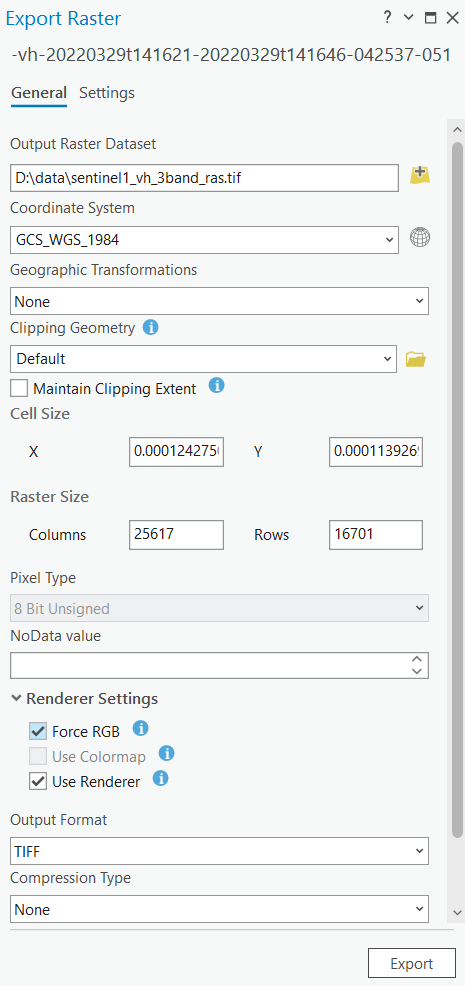

The resulting raster is generated from the Sentinel-1 GRD VH imagery using traditional histogram thresholding technique. The raster contains two classes, `permanent waterbodies` and `flood water`. This raster will be used as a `Classified Raster` in the `Export Training Data Using Deep Learning` tool.

<Item title:"flood_input_raster_for_training_data" type:Imagery Layer owner:api_data_owner>
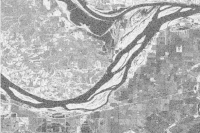

In [3]:
input_raster = gis_ent.content.get("b2d15ba81b65442180e7b1d1b9b708f9")
input_raster

The feature layer contains two classes: `1 = Permanent Waterbodies` and `2 = Flood Water`. The feature layer will be used as the `Input Feature Class` in the `Export Training Data For Deep Learning` tool.

<Item title:"flood_label_2classes" type:Feature Layer Collection owner:api_data_owner>
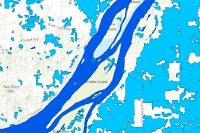

In [4]:
label_raster = gis_ent.content.get("2d52064d4eb54559b75ff4451cb6d52b")
label_raster

The polygon feature class will be used as `Input Mask Polygons` in the `Export Training Data For Deep Learning` tool to delineate the area where image chips will be created.

<Item title:"flood_aoi_mask" type:Feature Layer Collection owner:api_data_owner>
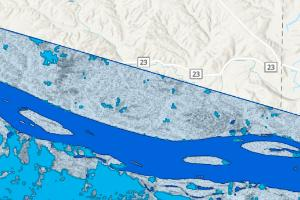

In [5]:
aoi = gis_ent.content.get("d378a12e00a24815a306965e1917601d")
aoi

The [Export Training Data For Deep Learning](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool is used to prepare training data for training a deep learning model. The tool is available in both `ArcGIS Pro` and `ArcGIS Enterprise`.

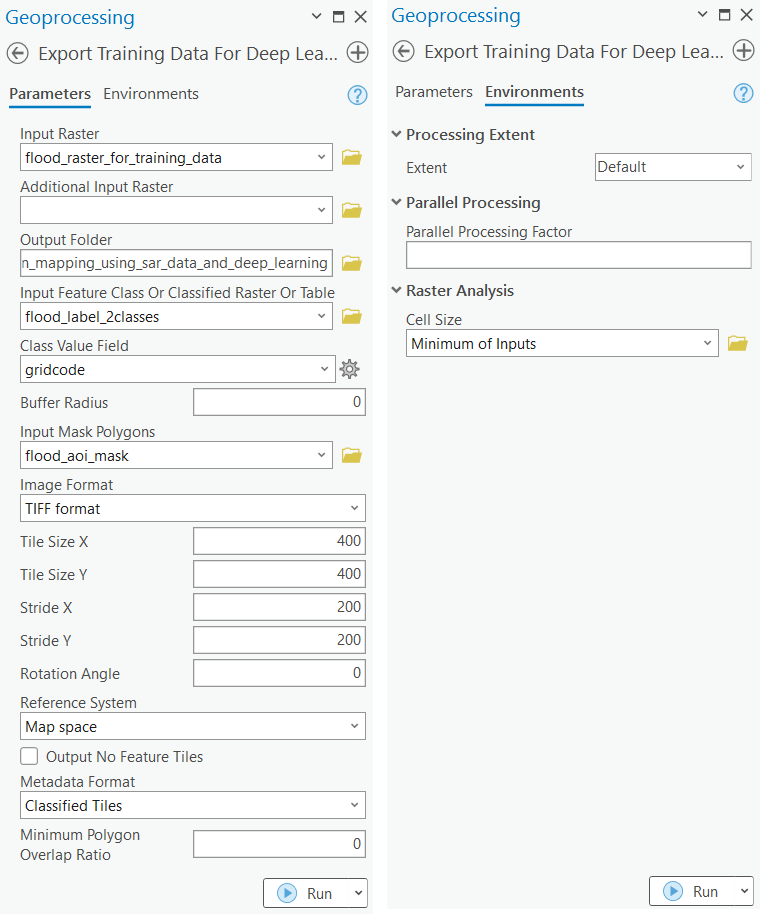

Next, we will utilize Jupyter Notebooks. Documentation on how to install and setup the necessary environment is available [here](https://developers.arcgis.com/python/guide/install-and-set-up/).

## Model training<a class="anchor" id="5"></a>

### Get training data<a class="anchor" id="6"></a>

We have already exported the data, and it can be directly downloaded using the following steps:

<Item title:"flood_inundation_mapping_using_sar_data_and_deep_learning" type:Image Collection owner:api_data_owner>
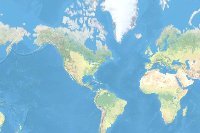

In [6]:
training_data = gis.content.get('c4f58fd8e21743d69c82a93b30c8b873')
training_data

In [7]:
filepath = training_data.download(file_name=training_data.name)

In [8]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [9]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

### Prepare data<a class="anchor" id="7"></a>

The prepare_data function takes a training data path as input and creates a fast.ai databunch with specified parameters, like transformation, batch size, split percentage, etc.

In [10]:
data = prepare_data(data_path, batch_size=4, chip_size=400)

### Visualize training data<a class="anchor" id="8"></a>

To get a sense of what the training data looks like, the `arcgis.learn.show_batch()` method will randomly select a few training chips and visualize them.

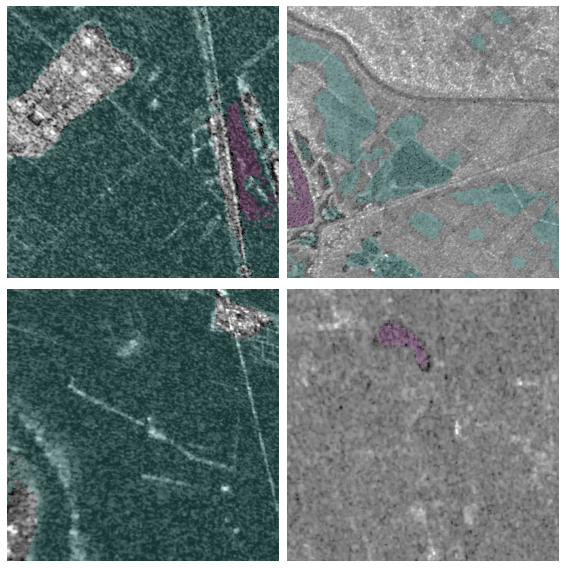

In [11]:
data.show_batch(rows=3)

### Load model architecture<a class="anchor" id="9"></a>

`arcgis.learn` provides the UnetClassifier model for per pixel classification that is based on a pretrained convnet, like ResNet, that acts as the `backbone`. More details about UnetClassifier can be found [here](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#unetclassifier).

In [12]:
# Create U-Net Model
unet = UnetClassifier(data, backbone='resnet34')

In [13]:
unet.unfreeze()

### Train the model<a class="anchor" id="10"></a>

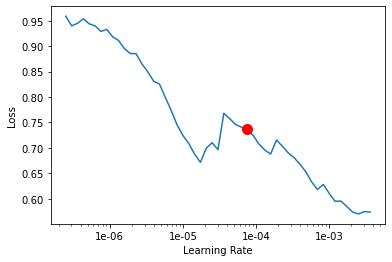

7.585775750291836e-05

In [14]:
lr = unet.lr_find()
lr

We are using the suggested learning rate above to train the model for 400 epochs.

In [15]:
unet.fit(100, lr=lr)

epoch,train_loss,valid_loss,accuracy,dice,time
0,0.056524,0.064984,0.976062,0.608772,06:45
1,0.062250,0.065558,0.976453,0.596853,03:28
2,0.054321,0.065829,0.974905,0.606779,03:29
3,0.055470,0.065657,0.975155,0.612507,03:38
4,0.057925,0.062683,0.975891,0.612544,03:41
5,0.046697,0.066485,0.975312,0.612030,03:38
6,0.048388,0.067163,0.974090,0.605625,03:34
7,0.057085,0.068184,0.974643,0.599440,03:37
8,0.057320,0.063318,0.976909,0.601846,03:39
9,0.055874,0.064139,0.976454,0.618239,03:39


We have trained the model for a further 300 epochs to improve model performance. For the sake of time, the cell below is commented out.

In [16]:
# model.fit(300)

### Visualize results in validation set<a class="anchor" id="11"></a>

It's a good practice to see results of the model vis-a-vis ground truth. The code below picks random samples and shows us ground truths and model predictions, side by side. This enables us to preview the results of the model within the notebook.

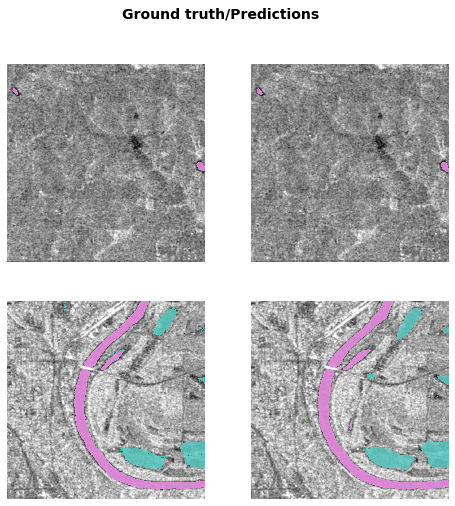

In [17]:
unet.show_results(rows=2, alpha=0.9)

### Evaluate model performance<a class="anchor" id="12"></a>

In [18]:
unet.accuracy()

0.978518545627594

As we have 2 classes (`1=permanent waterbodies` and `2=flood water`) for this segmentation task, we need to perform an accuracy assessment for each class. To achieve this, ArcGIS API for Python provides the `per_class_metrics` function that calculates a precision, recall, and f1 score for each class.

In [19]:
unet.per_class_metrics()

,NoData,1,2
precision,0.989588,0.869491,0.904360
recall,0.989450,0.868702,0.905547
f1,0.989519,0.869096,0.904953


### Save the model<a class="anchor" id="13"></a>

We will save the model that we trained as a 'Deep Learning Package' ('.dlpk' format). A Deep Learning Package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within the training data folder.

In [20]:
unet.save('flood_model', publish=True)

Published DLPK Item Id: 86d5806943024257a8a15fe17296b19b


WindowsPath('D:/2021/floods/sample_notebook/flood_400px_256strd_vh_full/models/flood_model')

## Model inferencing<a class="anchor" id="14"></a>

Using ArcGIS Pro, we can use the trained model on a test image/area to classify permanent waterbodies and flood inundated areas in the SAR satellite image.

After training the `UnetClassifier` model and saving the weights for classifying images, we can use the [Classify Pixels Using Deep Learning tool](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm) tool available in [ArcGIS pro](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm) and [ArcGIS Enterprise](https://enterprise.arcgis.com/en/portal/latest/use/classify-pixels-using-deep-learning.htm) for inferencing.

<Item title:"flood_model" type:Deep Learning Package owner:api_data_owner>
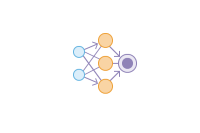

In [21]:
flood_model = gis.content.get('86d5806943024257a8a15fe17296b19b')
flood_model

In [2]:
raster_for_inferencing = gis.content.get('c6abe978dc854c20bf0664f6f7b43290')
raster_for_inferencing

<Item title:"st_peters_sar_inf_raster" type:Imagery Layer owner:api_data_owner>

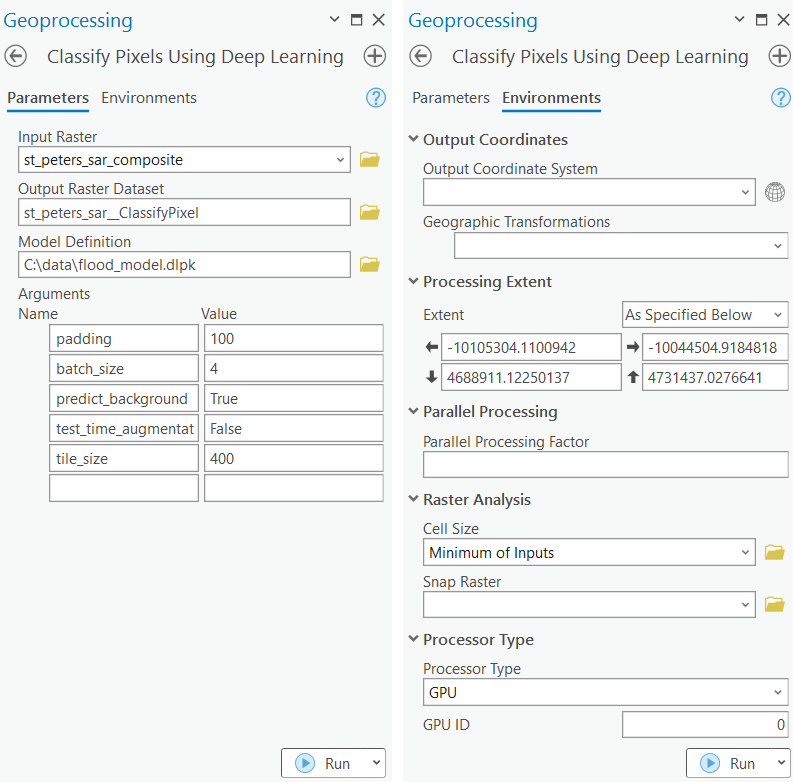

`with arcpy.EnvManager(processorType="GPU"):
 out_classified_raster = arcpy.ia.ClassifyPixelsUsingDeepLearning("sentinel1_3band_inference_raster", "https://deldev.maps.arcgis.com/sharing/rest/content/items/86d5806943024257a8a15fe17296b19b", "padding 100;batch_size 8;predict_background True;tile_size 400", "PROCESS_AS_MOSAICKED_IMAGE", None); out_classified_raster.save(r"C:\Users\shi10484\Documents\ArcGIS\Projects\flood2\flood2.gdb\inferenced_results")`

## Results visualization<a class="anchor" id="15"></a>

The classified output raster is generated using ArcGIS Pro. The output raster is published on the portal for visualization.

In [23]:
sar_ras2 = gis.content.get('427cd9a47eb544c59c1e965a56e72550')
inf_ras2 = gis.content.get('a7f2c8f23aa448d28fc14ec99b325ca8')

In [24]:
from arcgis.raster import colormap
inf_cmap2 = colormap(inf_ras2.layers[0], colormap=[[1, 7, 42, 108],[2, 0, 206, 209]])

### Create map widgets
Three map widgets are created showing flood inundation in different regions.

In [25]:
map1 = gis.map('St Peters, USA', 11)
map1.basemap='satellite'
map2 = gis.map('St Peters, USA', 11)
map2.add_layer(sar_ras2)
map3 = gis.map()
map3.add_layer(sar_ras2)
map3.add_layer(inf_cmap2)

### Set the map layout

In [26]:
from ipywidgets import HBox, VBox, Label, Layout

In [27]:
map1.sync_navigation(map2)
map2.sync_navigation(map3)

[Hbox and Vbox](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html?highlight=hbox) were used to set the layout of map widgets.

In [28]:
hbox_layout = Layout()
hbox_layout.justify_content = 'space-around'

hb1,hb2=HBox([Label('True Colour Image'),Label('Sentinel-1 Imagery'),Label('Predictions'),]),\
                HBox([Label('True Colour Image'),Label('Sentinel-1 Imagery'),Label('Predictions')])
hb1.layout,hb2.layout=hbox_layout,hbox_layout

### Flood inundation mapping<a class="anchor" id="16"></a>

The resulting predictions are provided as a map for better visualization. The results show the spatial distribution of flood water in the Midwestern US during the 2019 floods. Sentinel-1 VV imagery of May 2019 are used for the analysis. In the map widgets, it can be seen that the trained `UNetClassifier` model is able to identify permanent waterbodies and flood water, as well as differentiate between the two. The deep blue color represents permanent waterbodies and the cyan color represents flood water.

In [29]:
VBox([hb1,HBox([map1,map2,map3])])

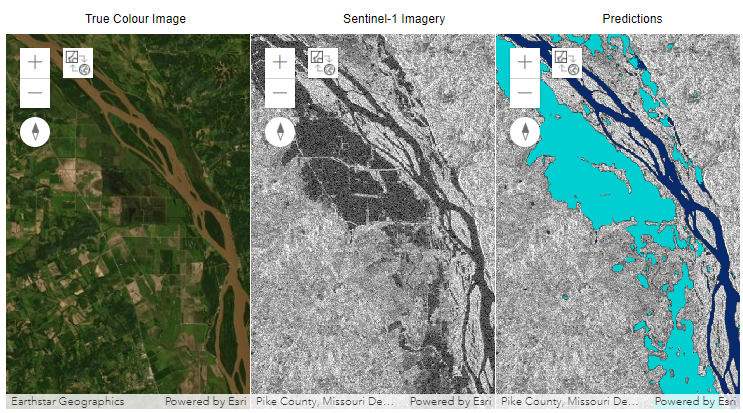

Three map widgets were created. The left widget displays natural color high resolution satellite imagery prior to flooding, the middle widget displays the sentinel-1 imagery during the flood event, and the right map widget displays the predictions of the trained UnetClassifier model. In the maps, St Louis city can be seen where the Illinois river and the Mississippi river converge. The model is able to identify river channels and differentiate from the flood water. The True Color Imagery can be used for visual interpretation for model accuracy.

### Estimation of flood inundated area (sq. km)<a class="anchor" id="17"></a>

The pixel size of the raster is required to calculate the area of flood inundated areas. We will use the `<raster>.properties.pixelSizeX` and `<raster>.properties.pixelSizeY` functions to find the Pixel size of the raster.

In [30]:
## Cellsize
ras2_cellsize_x = inf_ras2.layers[0].properties.pixelSizeX
ras2_cellsize_y = inf_ras2.layers[0].properties.pixelSizeY
print(ras2_cellsize_x, ras2_cellsize_y)

14.347297149746653 14.347297149746689


To calculate the area of land under flood water, we will use the `<raster>.attribute_table()` function to find the count of pixels per flood water class.

In [31]:
inf_ras2.layers[0].attribute_table()

{'fields': [{'name': 'Value',
   'type': 'esriFieldTypeInteger',
   'alias': 'Value',
   'sqlType': 'sqlTypeOther',
   'domain': None,
   'defaultValue': None},
  {'name': 'Count',
   'type': 'esriFieldTypeDouble',
   'alias': 'Count',
   'sqlType': 'sqlTypeOther',
   'domain': None,
   'defaultValue': None},
  {'name': 'Class',
   'type': 'esriFieldTypeString',
   'alias': 'Class',
   'sqlType': 'sqlTypeOther',
   'length': 1,
   'domain': None,
   'defaultValue': None}],
 'features': [{'attributes': {'Value': 1, 'Count': 1822630, 'Class': '1'}},
  {'attributes': {'Value': 2, 'Count': 5219135, 'Class': '2'}}]}

This study requires the calculation of the area of land under flood water in terms of square km. The raster uses the projected coordinate system (3857), which has pixels in meters.

In [32]:
## area in square kilometers
area_ras2_flood_water = (5219135*(ras2_cellsize_x*ras2_cellsize_y)/1000000)
area_ras2_flood_water

1074.332507457123

### Infrastructural inundation assessment<a class="anchor" id="18"></a>

The inferenced raster will be used to assess the infrasruture inundated in flood water.

In [33]:
The inferenced raster will be used to assess the infrasruture inundated in flood water.flood_raster = Raster("https://tiledimageservices6.arcgis.com/SMX5BErCXLM7eDtY/arcgis/rest/services/st_louis_flood_water/ImageServer",
                      gis=gis2,
                      engine="image_server")

The LULC raster for St. Louis is generated using the [Land Cover Classification (Sentinel-2)](https://deldev.maps.arcgis.com/home/item.html?id=afd124844ba84da69c2c533d4af10a58) pretrained model to assess the inundated areas per the LULC class.

In [34]:
lulc_raster = Raster("https://tiledimageservices6.arcgis.com/SMX5BErCXLM7eDtY/arcgis/rest/services/lulc_st_louis/ImageServer",
                        gis=gis2,
                        engine="image_server")

The flood raster will be converted to polygons using [convert_raster_to_feature](https://developers.arcgis.com/rest/services-reference/enterprise/convert-raster-to-feature.htm). We then use the import_data function to create a new feature layer containing the flood water polygons.

In [35]:
flood_poly = convert_raster_to_feature(flood_raster, 
                                    field='Value', 
                                    output_type='Polygon', 
                                    simplify=False, 
                                    output_name='flood_st_louis_poly'+str(datetime.now().microsecond), 
                                    gis=gis)

## Create dataframe from feature layer and get water polygons
dfm1 = flood_poly.layers[0].query('gridcode=2').sdf 

## Convert dataframe to feature layer
flood_poly = gis.content.import_data(dfm1, title='flood_water_poly'+str(datetime.now().microsecond))

Next, the LULC raster will be converted to polygons using [convert_raster_to_feature](https://developers.arcgis.com/rest/services-reference/enterprise/convert-raster-to-feature.htm). After getting the LULC polygons, we remove NODATA and Water polygons and use the `import_data` function to create a new feature layer containing the correct LULC polygons.

In [36]:
lulc_poly = convert_raster_to_feature(lulc_raster, 
                                    field='Value', 
                                    output_type='Polygon', 
                                    simplify=False, 
                                    output_name='lulc_st_louis_poly'+str(datetime.now().microsecond), 
                                    gis=gis)

## Create dataframe from feature layer and get water polygons
dfm2 = lulc_poly.layers[0].query('gridcode > 0 And gridcode < 5').sdf 

## Convert dataframe to feature layer
lulc_polygon = gis.content.import_data(dfm2, title='lulc_poly'+str(datetime.now().microsecond))

To get the LULC classes for the flood inundated areas, we will use the [overlay_layers](https://developers.arcgis.com/rest/analysis/api-reference/overlay-layers.htm) function.

In [37]:
inundated_lulc = overlay_layers(lulc_polygon.layers[0], 
                                flood_poly.layers[0], 
                                output_name='inundated_lulc'+str(datetime.now().microsecond),
                                gis=gis)

After getting the LULC classes for the flood inundated areas, we will dissolve the polygons on the basis of `gridcode`. The output feature layer will have the combined area of each class in `square miles` units.

In [38]:
lulc_dissolve = dissolve_boundaries(inundated_lulc, 
                               dissolve_fields=['gridcode'], 
                               output_name='dissolved_lulc'+str(datetime.now().microsecond),
                               gis=gis,
                               multi_part_features=True)

The resulting feature layer has a column for the area per class, but the corresponding LULC class name is missing. We will add the class names to the dataframe using the code below.

In [39]:
dfm4 = lulc_dissolve.layers[0].query().sdf
lulc_classes = ['Artificial surfaces', 'Agricultural areas', 'Forest and semi natural areas', 'Wetlands']
dfm4['LULC_Classes'] = lulc_classes
dfm5 = dfm4[['gridcode','AnalysisArea', 'LULC_Classes']].copy()
dfm5.rename(columns={'AnalysisArea': 'Area_in_square_miles'}, inplace=True)
dfm5

,gridcode,Area_in_square_miles,LULC_Classes
0,1,7.469743,Artificial surfaces
1,2,189.190674,Agricultural areas
2,3,5.561292,Forest and semi natural areas
3,4,14.224226,Wetlands


## Conclusion<a class="anchor" id="19"></a>

In this notebook, we have demonstrated how to use a UnetClassifier model with ArcGIS API for Python to extract flood water and permanent waterbodies. In Part 1, we covered how Sentinel-1 SAR data can be used for flood inundation mapping and monitoring. This process involved steps to prepare the input data, train a pixel-based classification model, visualize the results, generate accuracy metrics, and inferencing results on a test raster/area. Finally, in Part 2, we demonstrated the flood water inundated area in square kilometers and an infrastructural inundation assessment.